**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation.

In [ ]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 952.5 kB/s eta 0:00:00


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 171MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:

apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$

We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.




When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:

1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)

3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.


The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len:
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

fit_on_text takes in the message in words and creates a one-to-one mapping of each unique word to an integer based on their frequency of occurrence. More frequent words are assigned to smaller integer values, and less frequent words are assigned to larger integer values.

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

texts_to_sequences takes in the messages in words and uses the one-to-one mapping of word to integer created by fit_on_text to translate each message (review) from sequence of words into sequence of integers.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

The input text data (reviews) may have variable length, and thus the sequences of integers created by texts_to_sequence may have variable length. pad_sequences add zeros at the begining of the sequences of integers which are shorter than maxlen to ensure that all sequences of integers have same length.

pad_sequences is crucial for maintaining a consistent input length, allowing columnwise vectorization and enabling simultaneous processing at each time step in training (GRU).

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print("the sixth training message:",messages_train[5])
print("the sixth training label:",labels_test[5])

the sixth training message: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   10   89  118   85   11   17   34  106 1161  838   20
   11  145    3  191  326    2  235   52 1077   16    1   64   11  212
   19  671   18   57   43   10  292    1  333  113   52  333 1053 1947
   14    1  513    2   29  183    1  335    2 1407 1268  490   11 1184
 1712  296   41   85 1031   12  347   13   43   22  339   12    2  190
   12   13 1059  721 1075    9  239   13    1   88  152  173    4    1
   17  273  474   37   11   17   18   43  337    

Each word is represented by one-hot-encoding, ie. the first word -> the first non-zero integer, 10. The label is 0 (negative review). The length of the sixth training messages is shorter than maxlen. As expected, we add zeros at the begining of the sequence of integers to ensure that all sequences of integers have same length.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry.

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows.

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

`__init__` initialize the weights of the matrix that represents the transfromation of one-hot encoding to embedding coding.

`__call__` call the x row of the matrix, showing the embedding coding of the word with one-hot encoding x.

Given a sentence input ie. [10,48,37,...] the function will output the [10th,48th,37th,...] row of the transformation matrix, transfering each one-hot integer endcoding of word into the embedding coding vector, where the final result will be a matrix of size (length of the sentence, latent).

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

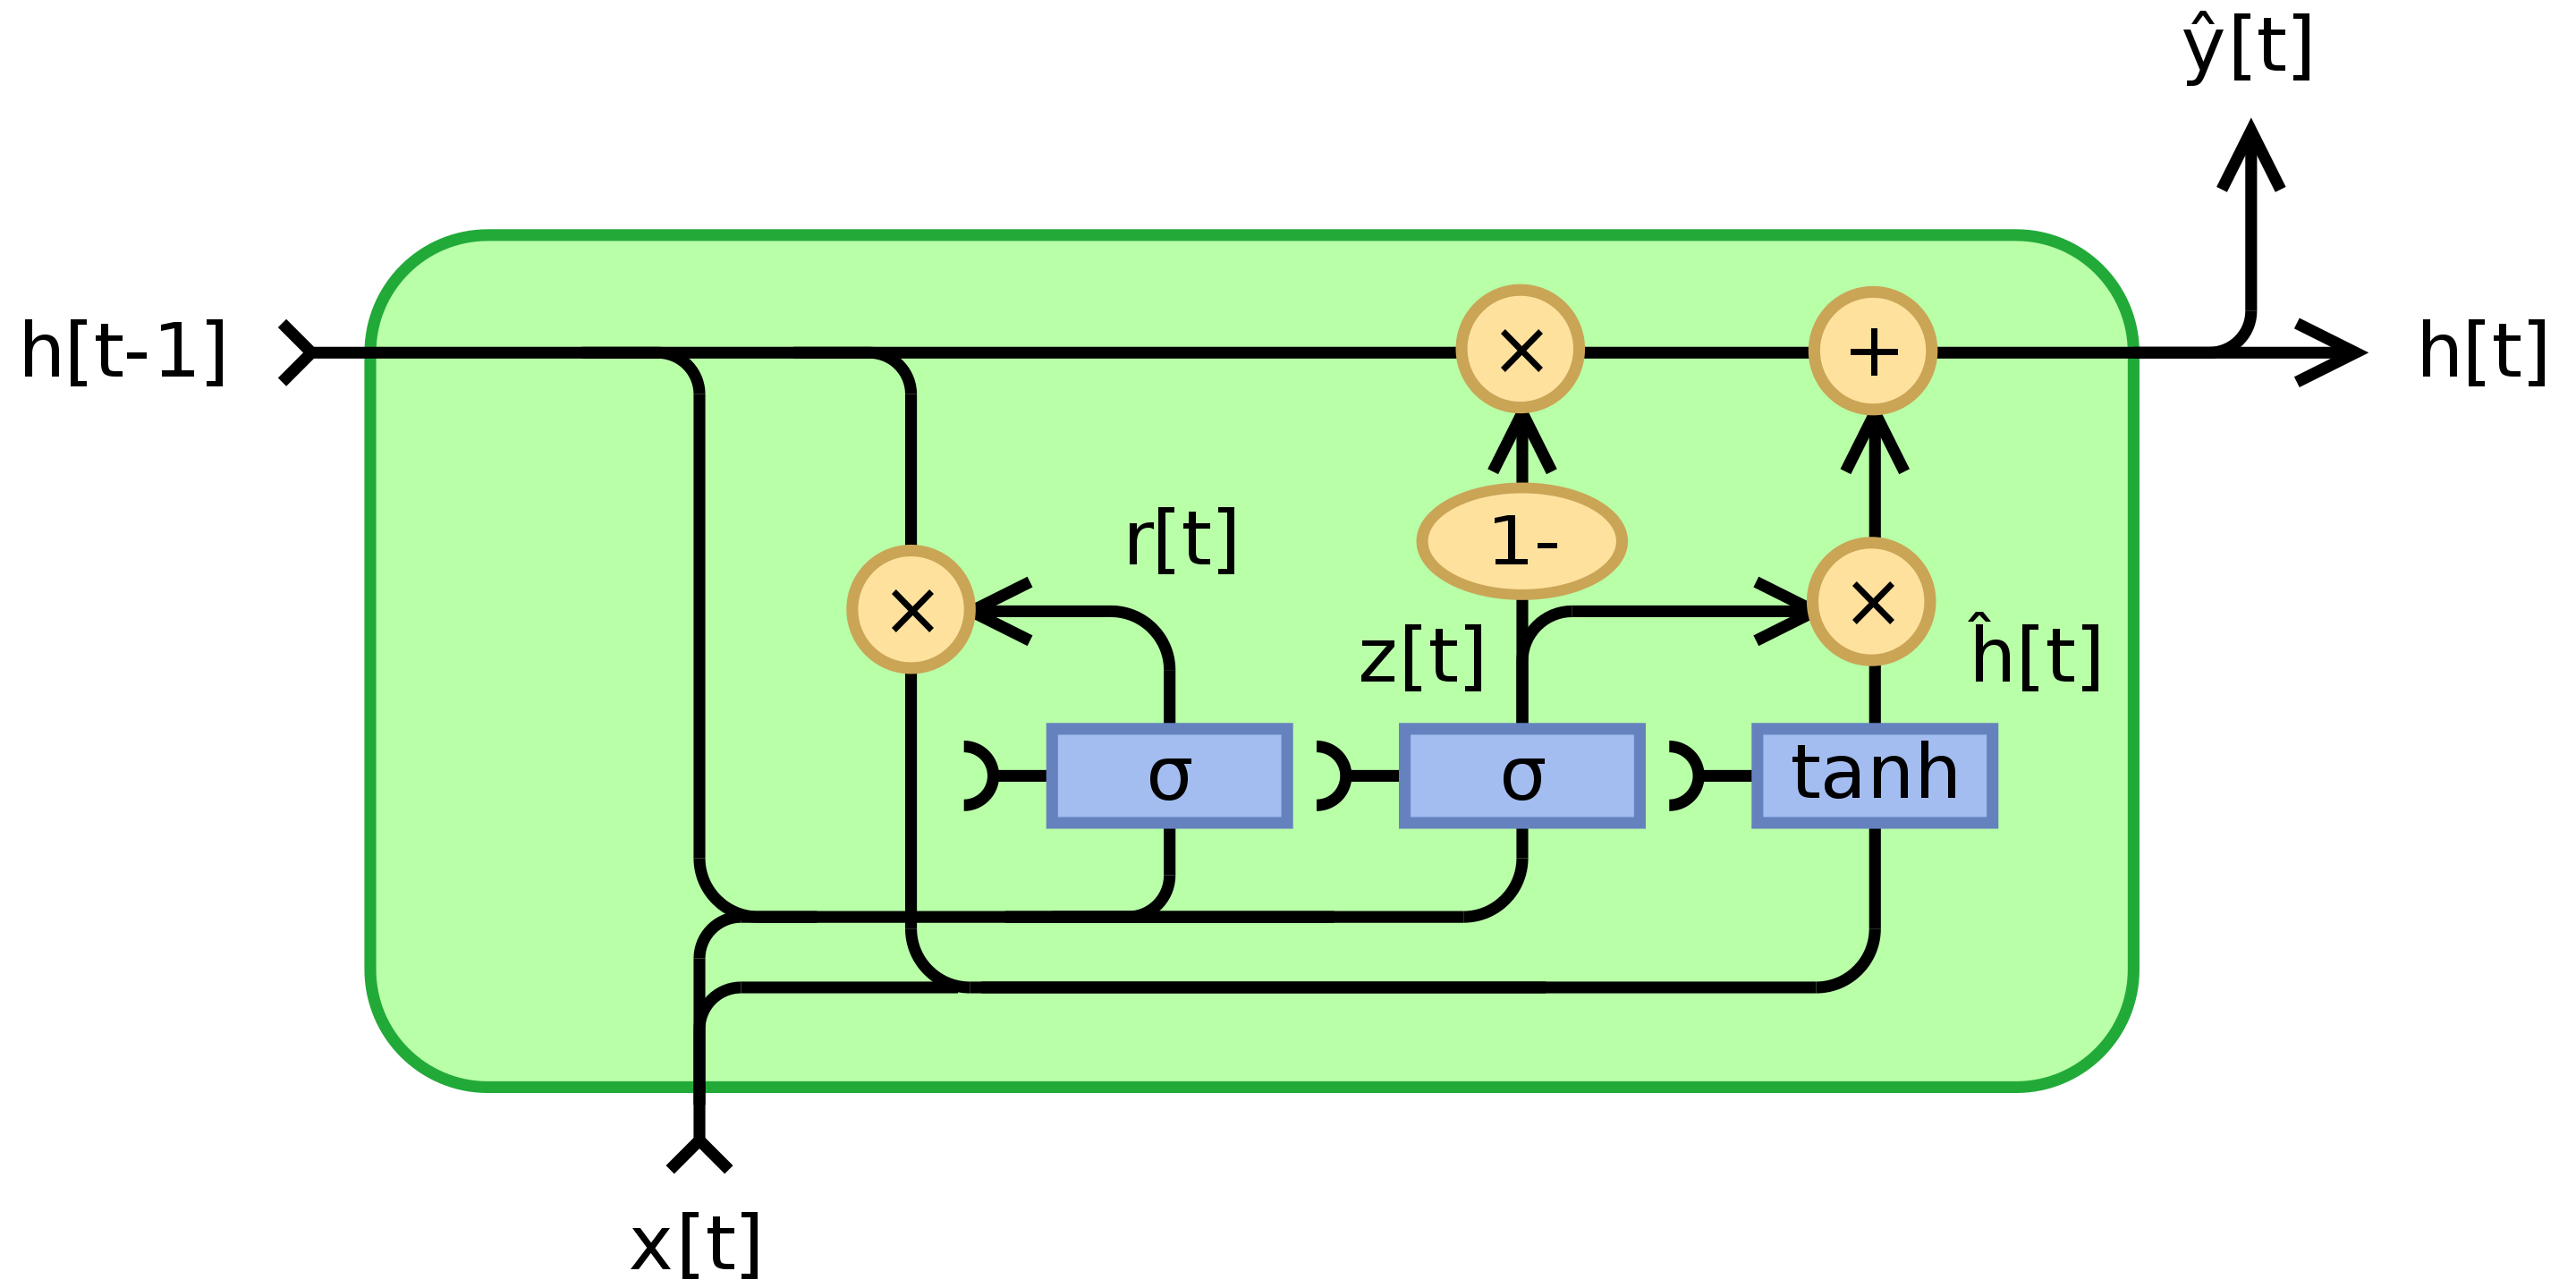

To learn more about GRU, please watch these short videos:

https://www.youtube.com/watch?v=8HyCNIVRbSU

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function.

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(x @ self.update_w + state @ self.update_u + self.update_b)

            # fill this in
            reset_gate = objax.functional.sigmoid(x @ self.reset_w + state @ self.reset_u + self.reset_b)

            # fill this in
            output_gate = jn.tanh(x @ self.output_w + (reset_gate * state) @ self.output_u + self.output_b)

            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

In [ ]:
def sum(sequence):
    def iteration(current_sum, add_this):
        previous_sum = current_sum
        current_sum = current_sum + add_this
        return current_sum, previous_sum

    initial_value = np.array(0)

    return lax.scan(iteration, initial_value, sequence)

sequence = np.array([1, 2, 3, 4, 5])
print(sum(sequence))
sequence = np.array([1, 2, 3, 4, 5, 6])
print(sum(sequence))

(Array(15, dtype=int32), Array([ 0,  1,  3,  6, 10], dtype=int32))
(Array(21, dtype=int32), Array([ 0,  1,  3,  6, 10, 15], dtype=int32))


lax.scan function is an iteration method, it takes in the iterating functon `iteration`, the initial value of the output `initial_value`, and the input to the iterating function at each time step `sequence` and iterating for `len(sequence)` time to generate the final output.

In the above example, the initial value of `current_sum` is set to be zero. At each time step `t`, `iteration` takes in the `current_sum` and add it by `add_this`, where `add_this` is `sequence[t-1]`. After iterating through the entire sequence, the final result of `current_sum` is the sum of the sequence.

lax.scan will return a tuple of two. The first output is the final value of `current_sum`, that is the sum after iterating through the entire sequence. The second output is a vector of size `len(sequence)`, in which the value of `previous_sum` at each time step is stored.

lax.scan is useful in iterating over sequences that requires a state that evolves with each iteration over the sequence. (`current_sum` in the above example) It can return the final value of the state while also keep track of the intermediate value of the state.

# The classifier

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(size = max_len, latent = embedding_size),
    GRU(nin = embedding_size,nout = num_hidden_units_GRU),
    objax.nn.Linear(nin = num_hidden_units_GRU,nout = num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(nin = num_hidden_units,nout=2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU.

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here
train_acc_epoch = []
val_acc_epoch = []
for epoch in range(num_epochs):
    train_indices = np.arange(len(training_data[0]))
    np.random.shuffle(train_indices)
    for it in range(0,(training_data[0]).shape[0],batch_size):
        batch = train_indices[it:it + batch_size]
        train_op(training_data[0][batch],training_data[1][batch],learning_rate)
    train_acc_epoch.append(accuracy(training_data))
    val_acc_epoch.append(accuracy(validation_data))
    print('Epoch %04d Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, accuracy(training_data)*100, accuracy(validation_data)*100))
test_acc = accuracy(test_data)*100
print("Test accuracy is: ",test_acc)

Epoch 0001 Training Accuracy 52.77 Validation Accuracy 54.26
Epoch 0002 Training Accuracy 54.74 Validation Accuracy 55.34
Epoch 0003 Training Accuracy 56.67 Validation Accuracy 57.40
Epoch 0004 Training Accuracy 57.60 Validation Accuracy 56.88
Epoch 0005 Training Accuracy 61.38 Validation Accuracy 62.04
Epoch 0006 Training Accuracy 62.42 Validation Accuracy 61.40
Epoch 0007 Training Accuracy 67.10 Validation Accuracy 67.38
Epoch 0008 Training Accuracy 56.76 Validation Accuracy 56.28
Epoch 0009 Training Accuracy 54.44 Validation Accuracy 53.50
Epoch 0010 Training Accuracy 67.98 Validation Accuracy 68.48
Epoch 0011 Training Accuracy 68.19 Validation Accuracy 68.84
Epoch 0012 Training Accuracy 69.18 Validation Accuracy 69.98
Epoch 0013 Training Accuracy 65.04 Validation Accuracy 65.38
Epoch 0014 Training Accuracy 63.33 Validation Accuracy 63.88
Epoch 0015 Training Accuracy 71.42 Validation Accuracy 71.44
Epoch 0016 Training Accuracy 70.39 Validation Accuracy 70.82
Epoch 0017 Training Accu

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

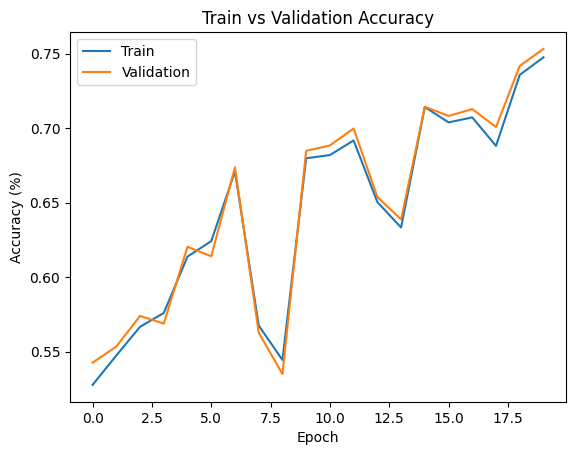

Average generalization gap is:  0.34412473905831575 %


In [ ]:
plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

avg_gen_gap = np.abs(np.average(np.array(val_acc_epoch)-np.array(train_acc_epoch)))*100
print("Average generalization gap is: ", avg_gen_gap,"%")

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(size = max_len, latent = embedding_size),
    GRU(nin = embedding_size,nout = num_hidden_units_GRU),
    objax.nn.Linear(nin = num_hidden_units_GRU,nout = num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(nin = num_hidden_units,nout=2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here
train_acc_epoch = []
val_acc_epoch = []
for epoch in range(num_epochs):
    train_indices = np.arange(len(training_data[0]))
    np.random.shuffle(train_indices)
    for it in range(0,(training_data[0]).shape[0],batch_size):
        batch = train_indices[it:it + batch_size]
        train_op(training_data[0][batch],training_data[1][batch],learning_rate)
    train_acc_epoch.append(accuracy(training_data))
    val_acc_epoch.append(accuracy(validation_data))
    print('Epoch %04d Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, accuracy(training_data)*100, accuracy(validation_data)*100))
test_acc = accuracy(test_data)*100
print("Test accuracy is: ",test_acc)

Epoch 0001 Training Accuracy 74.08 Validation Accuracy 75.18
Epoch 0002 Training Accuracy 74.49 Validation Accuracy 74.62
Epoch 0003 Training Accuracy 76.15 Validation Accuracy 76.76
Epoch 0004 Training Accuracy 73.36 Validation Accuracy 73.96
Epoch 0005 Training Accuracy 75.44 Validation Accuracy 75.86
Epoch 0006 Training Accuracy 75.79 Validation Accuracy 76.06
Epoch 0007 Training Accuracy 74.63 Validation Accuracy 74.78
Epoch 0008 Training Accuracy 74.54 Validation Accuracy 74.52
Epoch 0009 Training Accuracy 75.69 Validation Accuracy 75.42
Epoch 0010 Training Accuracy 75.78 Validation Accuracy 76.56
Epoch 0011 Training Accuracy 76.67 Validation Accuracy 76.32
Epoch 0012 Training Accuracy 77.20 Validation Accuracy 77.18
Epoch 0013 Training Accuracy 77.41 Validation Accuracy 77.20
Epoch 0014 Training Accuracy 77.89 Validation Accuracy 77.44
Epoch 0015 Training Accuracy 78.81 Validation Accuracy 78.72
Epoch 0016 Training Accuracy 79.45 Validation Accuracy 79.12
Epoch 0017 Training Accu

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

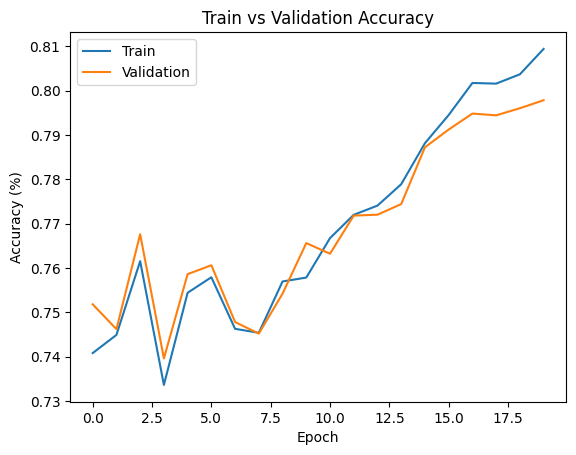

Average generalization gap is:  0.05037427181378007 %


In [ ]:
plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

avg_gen_gap = np.abs(np.average(np.array(val_acc_epoch)-np.array(train_acc_epoch)))*100
print("Average generalization gap is: ", avg_gen_gap,"%")

#compare the result

The test accuracy of Adam optimizer is 80.48%, which is higher than the test accuracy of the SGD optimizer (75.16%). During training, there is less fluctuation on the training accuracy and validation accuracy using Adam optimizer than SGD optimizer.

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam adapts the learning rates for each parameter individually by calculating the adaptive learning rates based on the past gradients, making it less reliant on manually tuning the learning rate as in SGD. Thus, Adam is useful in tackling complex neural networks involving a large number of parameters.

# Early Stopping

**Questions 16** [3 points]:
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(size = max_len, latent = embedding_size),
    GRU(nin = embedding_size,nout = num_hidden_units_GRU),
    objax.nn.Linear(nin = num_hidden_units_GRU,nout = num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(nin = num_hidden_units,nout=2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here
train_acc_epoch = []
val_acc_epoch = []
val_loss_epoch = []
min_loss = np.inf
patience = 0
for epoch in range(num_epochs):
    train_indices = np.arange(len(training_data[0]))
    np.random.shuffle(train_indices)
    for it in range(0,(training_data[0]).shape[0],batch_size):
        batch = train_indices[it:it + batch_size]
        train_op(training_data[0][batch],training_data[1][batch],learning_rate)
    train_acc_epoch.append(accuracy(training_data))
    val_acc_epoch.append(accuracy(validation_data))

    val_loss = (loss_function(validation_data[0], validation_data[1]))
    if val_loss < min_loss:
        patience = 0
        min_loss = val_loss
    else:
        patience += 1

    print('Epoch %04d Training Accuracy %.2f Validation Accuracy %.2f Patience %d' % (epoch + 1, accuracy(training_data)*100, accuracy(validation_data)*100, patience))

    if patience == max_patience_window:
        print("See no improvement over 5 epochs")
        break

test_acc = accuracy(test_data)*100
print("Test accuracy is: ",test_acc)

Epoch 0001 Training Accuracy 71.50 Validation Accuracy 72.70 Patience 0
Epoch 0002 Training Accuracy 74.02 Validation Accuracy 73.96 Patience 0
Epoch 0003 Training Accuracy 74.18 Validation Accuracy 74.34 Patience 0
Epoch 0004 Training Accuracy 74.74 Validation Accuracy 75.36 Patience 0
Epoch 0005 Training Accuracy 73.69 Validation Accuracy 74.54 Patience 1
Epoch 0006 Training Accuracy 74.81 Validation Accuracy 75.56 Patience 0
Epoch 0007 Training Accuracy 75.53 Validation Accuracy 75.94 Patience 0
Epoch 0008 Training Accuracy 75.94 Validation Accuracy 76.52 Patience 0
Epoch 0009 Training Accuracy 76.43 Validation Accuracy 76.70 Patience 0
Epoch 0010 Training Accuracy 76.94 Validation Accuracy 77.20 Patience 1
Epoch 0011 Training Accuracy 77.55 Validation Accuracy 78.64 Patience 0
Epoch 0012 Training Accuracy 78.30 Validation Accuracy 79.22 Patience 0
Epoch 0013 Training Accuracy 78.57 Validation Accuracy 79.14 Patience 0
Epoch 0014 Training Accuracy 78.78 Validation Accuracy 79.16 Pat

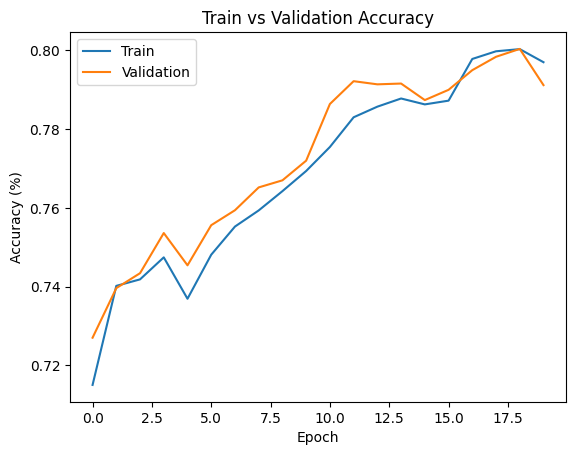

Average generalization gap is:  0.3697499632835388 %


In [ ]:
plt.title("Train vs Validation Accuracy")
plt.plot(train_acc_epoch, label="Train")
plt.plot(val_acc_epoch, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(loc='best')
plt.show()

avg_gen_gap = np.abs(np.average(np.array(val_acc_epoch)-np.array(train_acc_epoch)))*100
print("Average generalization gap is: ", avg_gen_gap,"%")

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The best model is gru_rnn3.

The best validation accuracy is: 80.04%

The test accuracy is: 79.38%

# Model cards

Our invited guest lecturer Deborah Raji presented her research about model cards as part of her lecture. In this last question, you are encouraged to read about model cards in [the publication by Mitchell et al.](https://arxiv.org/abs/1810.03993) co-authored by Deborah Raji.

**Question 18** [3 points] Write a model card for the model you developed in this assignment. Your card should at least contain 3 sections described in Figure 1 of the [paper by Mitchell et al.](https://arxiv.org/abs/1810.03993): Model Details, Intended Use, Metrics.

# GRU-RNN3
# Model Details
*   Developed by Zihuan Jiang at University of Toronto
*   Model Date: 2023-12-06
*   Model Version: v3
*   Model Type: GRU-RNN with Adam optimizer
*   Trained for positive/negative movie review classification

# Intended Use
*   Primary intended to use for ECE421 Fall 2023 Assignment 5

# Metrics
*   Best Validation Accuracy: 80.04%
*   Best Training Accuracy: 80.04%
*   Generalization Gap: 0.37%
*   Test Accuracy: 79.38%